In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [2]:
# get the stocks data 

!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2024-04-17 11:29:40--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: 'sp500sub.csv'

sp500sub.csv        100%[===================>]  24.29M  12.1MB/s    in 2.0s    

2024-04-17 11:29:43 (12.1 MB/s) - 'sp500sub.csv' saved [25473876/25473876]



In [16]:
df = pd.read_csv('sp500sub.csv', index_col = 0, parse_dates=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [17]:
# get IBM stock prices 

ibm = df[df.Name == 'IBM'][['Close']].copy()

ibm['LogClose'] = np.log(ibm['Close'])

ibm['DiffLClose'] = ibm['LogClose'].diff()

ibm.head()


,Close,LogClose,DiffLClose
Date,,,
2010-01-04,132.449997,4.886205,NaN
2010-01-05,130.850006,4.874052,-0.012154
2010-01-06,130.000000,4.867534,-0.006517
2010-01-07,129.550003,4.864067,-0.003468
2010-01-08,130.850006,4.874052,0.009985


In [18]:
# train, test 

Ntest = 12

train, test = ibm[:-Ntest], ibm[-Ntest:]

In [19]:
# We will prepare feature and target (differenced log) data suitable to use previous 21 values in the series to predict the next

series = ibm['DiffLClose'].to_numpy()[1:] # first entry in NaN due to differencing

T = 21

X = list()
Y =list()

for t in range(len(series)-T): # -T because there is no sliding window of 21 after a certain index towards the end of the series

    x = series[t:t+T] # take 0th to 20th, 1th to 21th, ... indexed values as the X 
    X.append(x)

    y = series[t+T] # set the 21th, 22th, ... as the corresponding target 
    Y.append(y)

X = np.array(X)
y = np.array(Y)
N = len(X) # number of observations

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (2241, 21), y shape: (2241,)


In [20]:
X_train, y_train = X[:-Ntest], y[:-Ntest]
X_test, y_test = X[-Ntest:], y[-Ntest:]

X_train.shape, y_train.shape

((2229, 21), (2229,))

In [21]:
# Boolean indexing according to train test split 

train_idx = ibm.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable as there is no target 

In [22]:
# last training data required to turn the differenced predictions to actual log close 

last_train = train.iloc[-1]['LogClose']

test_LClose = ibm.iloc[-Ntest:]['LogClose'] # test log sales required to compute test rmse for mstep fcast

In [23]:
# Compute the previous values needed make un-differenced predictions  

ibm['ShiftLClose']= ibm['LogClose'].shift(1)

prev = ibm['ShiftLClose']

In [42]:
# define a helper function that performs one and multi-step forecast 

def onesd_and_msd_fcast(model, name): 

    model.fit(X_train, y_train)
    print(f"One-step forecast for {name}:")

    # store one-step forecast to df
    ibm.loc[train_idx, f"{name}_1s_train"] =  prev[train_idx] + model.predict(X_train)
    ibm.loc[test_idx, f"{name}_1s_test"] = prev[test_idx] + model.predict(X_test)

    #RMSE of one-step forecast 
    rmse_1s = mean_squared_error(test_LClose, ibm.loc[test_idx, f"{name}_1s_test"], squared = False)
    print(f'Test RMSE for one-step: {rmse_1s:.3f}')

    # generate incremental multi-step forecast

    ms_preds = list()

    # first test input 
    last_x = X_test[0]

    while len(ms_preds) < Ntest:

        # get the first prediction for the differenced data
        pred = model.predict(last_x.reshape(1,-1))[0]

        ms_preds.append(pred)
        print(pred)

        # update the test series by assigning the last prediction 

        last_x = np.roll(last_x, -1)
        last_x[-1] = pred

    # store the multi-step test forecast 
    ibm.loc[test_idx, f"{name}_ms_test"] = last_train + np.cumsum(ms_preds)

    print(f"Multi-step forecast for {name}:")
    #RMSE of multi-step forecast 
    rmse_ms = mean_squared_error(test_LClose, ibm.loc[test_idx, f"{name}_ms_test"], squared = False)
    print(f'Test RMSE for multi-step: {rmse_ms:.3f}')

    # plot the predictions together 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogClose', f"{name}_1s_train", f"{name}_1s_test", f"{name}_ms_test"]

    ibm.iloc[-20:][plot_cols].plot(ax= axes)

    axes.grid()

One-step forecast for LR:
Test RMSE for one-step: 0.021
0.002142751587089782
0.001070084385466027
0.00037788782014041027
0.0008383874689552767
0.0002145768475370443
0.0005635940684397937
-0.001211433463100813
0.0004902639407983038
-0.00022122946984380745
-0.0007452446314320551
-0.00029365238076129347
0.0006235714578328554
Multi-step forecast for LR:
Test RMSE for multi-step: 0.065


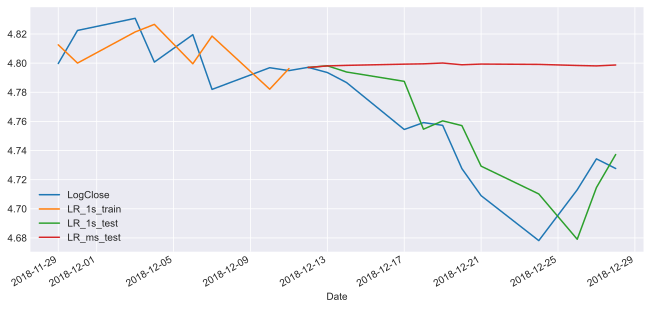

In [43]:
onesd_and_msd_fcast(LinearRegression(), 'LR')

one step forecast using a linear regression just lags the time series to make predictions which makes sense! On the other hand, multi-step forecast is pretty much a straight line because the differenced predictions fluctuates around 0 and so does their cumsum at each forecast horizon $h = 1,\dots,12$. This makes sense as the differenced data also fluctuates around zero so a linear regression model (with 21 features) of such a data would lead to a differenced prediction around zero! 

In [34]:
# prepare multi-output supervised dataset 
# we will use past T values to predict next Ty values

Tx = T # T = 21
Ty = Ntest # given past 21 values predict the next 12

Xm = list()
Ym =list()

for t in range(len(series)-Tx-Ty+1): # -Tx-Ty because there is no sliding window of 21 X values with the corresponding 12 y labels

    x = series[t:t+Tx] # take 0th to 20th, 1th to 21th, ... indexed val as the X 
    Xm.append(x)

    y = series[t+Tx:t+Tx+Ty] # set the 21th, 22th, ... as the corresponding target 
    Ym.append(y)

Xm = np.array(Xm)
ym = np.array(Ym)
N = len(Xm) # number of observations

print(f"X shape: {Xm.shape}, y shape: {ym.shape}")

X shape: (2230, 21), y shape: (2230, 12)


In [35]:
# train-test split 

X_train_m, y_train_m = Xm[:-1], ym[:-1] # all but the last values are training since we would like to forecast for the final Ntest = 12 values 

X_test_m, y_test_m = Xm[-1:], ym[-1:]

print(f"X_test shape: {X_test_m.shape}, y_test shape: {y_test_m.shape}")

X_test shape: (1, 21), y_test shape: (1, 12)


In [39]:
# define another helper function for multi_output forecasting 

def mod_fcast(model, name):

    model.fit(X_train_m, y_train_m)

    # save the predictions to df 

    ibm.loc[test_idx, f'{name}_mo_test'] = last_train + np.cumsum(model.predict(X_test_m).flatten())
    print(f'Multi-output forecast for {name}:')
    
    # rmse 
    rmse = mean_squared_error(test_LClose, ibm.loc[test_idx, f'{name}_mo_test'], squared = False)
    print(f'Test RMSE for multi-output {name}: {rmse:.3f}')

    # plot 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogClose', f"{name}_1s_train", f"{name}_1s_test", f"{name}_ms_test", f"{name}_mo_test"]

    ibm.iloc[-100:][plot_cols].plot(ax= axes)

    axes.grid()

Multi-output forecast for LR:
Test RMSE for multi-output LR: 0.068


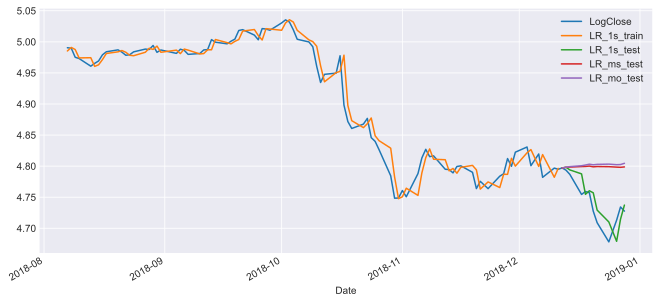

In [40]:
mod_fcast(LinearRegression(),'LR')

One-step forecast for SVR:
Test RMSE for one-step: 0.020
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
-0.0007427325767701554
Multi-step forecast for SVR:
Test RMSE for multi-step: 0.056


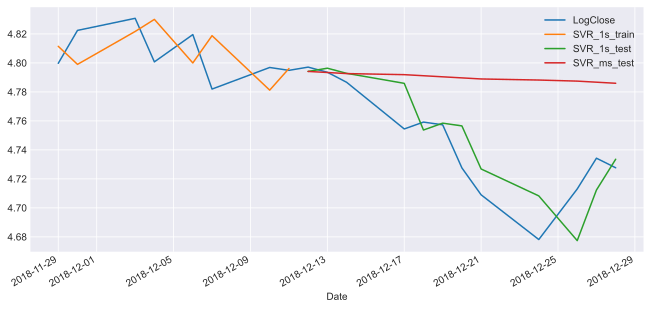

In [44]:
#  Lets try the non-linear models 

onesd_and_msd_fcast(SVR(),'SVR')

One-step forecast for RFR:
Test RMSE for one-step: 0.022
0.009433199965021996
0.0019352576140726275
0.0024308833054053204
0.003897590450435313
-0.0021413387129873397
0.0033450310415886
-0.0004156457177051909
0.000909326354773654
-0.0026908486189987355
-0.0014992353329327912
0.0021037046198603628
0.0021102713984586254
Multi-step forecast for RFR:
Test RMSE for multi-step: 0.076


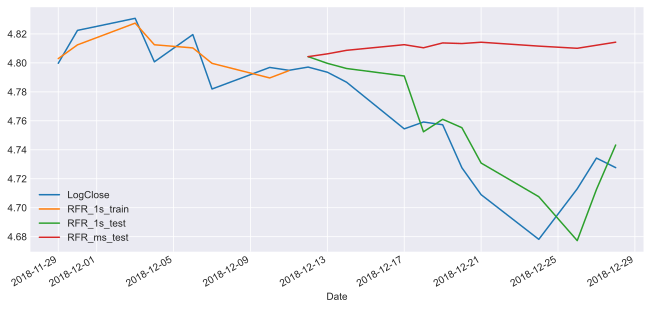

In [45]:
onesd_and_msd_fcast(RandomForestRegressor(), 'RFR')

Multi-output forecast for RFR:
Test RMSE for multi-output RFR: 0.066


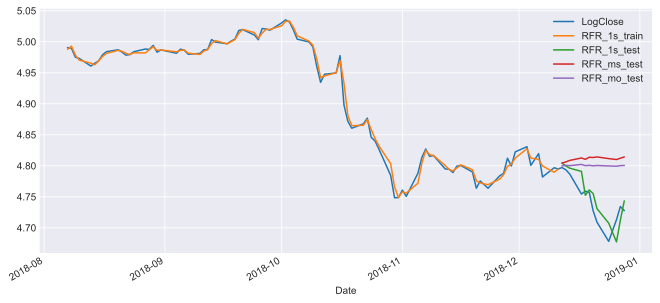

In [46]:
mod_fcast(RandomForestRegressor(), 'RFR')

Notice the the success of the RFR on the training set howeever, it fails miserably on the test set! 

So the lesson to take home is that non-linear models fail to predict the stock returns as bad as the linear models! 
 